# Notebook for testing Monte Carlo Dropout 

https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571

In [1]:
import sys
import os
import pandas as pd
import numpy as np

module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src')
import audio_time_series_classification as preproject
import utility

sys.path.insert(1, module_path + '/src/models/')
import helper
import librosa
from sklearn.decomposition import PCA
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.feature_selection import SelectKBest, chi2
from sktime.utils.data_processing import from_nested_to_2d_array
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import classification_report



from sklearn import preprocessing
from keras.utils import np_utils
import keras
from time import time

figure_path = module_path + '/figures/'

from keras.models import Model
from sklearn import metrics
from scipy.special import entr

from sklearn.utils import shuffle
import pickle
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense

from sklearn.preprocessing import MinMaxScaler

plot_label = 'noise'
n_classes = 2

# Importing dataset

In [2]:
X_train, y_train_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/minimal_dataset_{n_classes}class_TRAIN.ts')
X_test, y_test_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/minimal_dataset_{n_classes}class_TEST.ts')
X_val, y_val_ = load_from_tsfile_to_dataframe(module_path + f'/data/ts_files/minimal_dataset_{n_classes}class_VAL.ts')

X_train, y_train_= shuffle(X_train, y_train_, random_state = 42)

X_train, X_test, X_val = from_nested_to_2d_array(X_train), from_nested_to_2d_array(X_test), from_nested_to_2d_array(X_val)

cols = np.arange(len(X_test.columns))
X_train.columns, X_test.columns, X_val.columns = cols, cols, cols

y_train_, y_test_, y_val_ = pd.Series(y_train_), pd.Series(y_test_), pd.Series(y_val_)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()

X_train, y_train_= shuffle(X_train, y_train_, random_state = 42)
X_val, y_val_= shuffle(X_val, y_val_, random_state = 42)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

le = preprocessing.LabelEncoder()

le.fit(y_train_)
num_classes = len(le.classes_)
y_train = le.transform(y_train_)
y_test = le.transform(y_test_)
y_val = le.transform(y_val_)

y_train = np_utils.to_categorical(y_train, num_classes = num_classes)
y_test = np_utils.to_categorical(y_test, num_classes = num_classes)
y_val = np_utils.to_categorical(y_val, num_classes = num_classes)

# Using dropout with CNN to measure model uncertainty



In [3]:
def predict_proba(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.stack(preds).mean(axis=0)
     
def predict_class(X, model, num_samples):
    proba_preds = predict_proba(X, model, num_samples)
    return np.argmax(proba_preds, axis=1), proba_preds

def ECE_score(y_test, y_prob,  n_bins=10):
    #py = np.array(py)
    #y_test = np.array(y_test)
    if y_test.ndim > 1: # If y_test is a one-hot vector
        y_test = np.argmax(y_test, axis=1)
    py_index = np.argmax(y_prob, axis=1)
    py_value = []
    for i in range(y_prob.shape[0]):
        py_value.append(y_prob[i, py_index[i]])
    py_value = np.array(py_value)
    acc, conf = np.zeros(n_bins), np.zeros(n_bins)
    Bm = np.zeros(n_bins)
    for m in range(n_bins):
        a, b = m / n_bins, (m + 1) / n_bins
        for i in range(y_prob.shape[0]):
            if py_value[i] > a and py_value[i] <= b:
                Bm[m] += 1
                if py_index[i] == y_test[i]:
                    acc[m] += 1
                conf[m] += py_value[i]
        if Bm[m] != 0:
            acc[m] = acc[m] / Bm[m]
            conf[m] = conf[m] / Bm[m]
    ece = 0
    for m in range(n_bins):
        ece += Bm[m] * np.abs((acc[m] - conf[m]))
    return ece / sum(Bm)

def get_accuracy_confidence_curve(y_test, y_pred, prob):
    limits = np.linspace(0.5, 0.95, 10)
    ms = []
    for n in limits:
        indices = np.where(prob> n)[0]
        m = metrics.accuracy_score(y_test[indices],y_pred[indices])
        ms.append(m)
    return ms, limits

def count_region(bottom, top, probs):
    b = (probs < top) & (probs >= bottom)
    return np.sum(b)

def get_count_cuve(y_prob):
    regions = np.linspace(0, 1.0001, 11)
    counts = []
    for r in regions:
        counts.append(count_region(r, r + 0.1, y_prob))
    return counts

class MonteCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
    
def manipulate_noise(data, noise_factor, random_state):
    np.random.seed(seed=random_state)
    noise = np.random.randn(len(data))
    #print(noise)
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def manipulate_pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def manipulate_shift(data, shift_factor):
    return np.array([(x + shift_factor*np.var(x)) for (i,x) in enumerate(data)])

pitch_Xs = []


pitch_factor = np.linspace(1, 30, 5)
for pitch in pitch_factor:
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])
    X_test_noise = np.array([manipulate_pitch(x, 8000, pitch) for x in X_test])
    
    X_test_noise = X_test_noise.reshape(X_test_noise.shape[0],X_test_noise.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
    pitch_Xs.append(X_test_noise)
    
    
noise_Xs = []

noise_factor = np.linspace(0.0001, 0.1, 5)
for noise in noise_factor:
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])
    X_test_noise = np.array([manipulate_noise(x, noise,i) for (i,x) in enumerate(X_test)])
    
    X_test_noise = X_test_noise.reshape(X_test_noise.shape[0],X_test_noise.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
    noise_Xs.append(X_test_noise)
    
    
shift_Xs = []

shift_factor = np.linspace(2, 15, 5)
for shift in shift_factor:
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])
    X_test_noise = manipulate_shift(X_test, shift)
    
    X_test_noise = X_test_noise.reshape(X_test_noise.shape[0],X_test_noise.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
    shift_Xs.append(X_test_noise)
    
plot_factor = {
    'pitch': pitch_Xs,
    'noise' : noise_Xs,
    'shift' : shift_Xs
}

factors = {
    'pitch': pitch_factor,
    'noise' : noise_factor,
    'shift' : shift_factor
}

# Deep ensemble model


In [7]:
from tensorflow import math
from keras import backend as K
from keras.layers import Input, Dense, Layer, Dropout, Conv1D, Flatten, MaxPooling1D
from keras.models import Model
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        fir = 0.5*math.log(sigma)
        sec = 0.5*math.divide(math.square(y_true - y_pred), sigma)
        res = math.reduce_mean(fir + sec, axis = -1) + 1e-6
        return res
    return gaussian_loss



class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(1500, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(1500, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        #print(self.kernel_1.shape)
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
       
        return [output_mu, output_sig_pos]
    
    def compute_output_shape(self, input_shape):
        
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]
    

def create_trained_network(X_train, y_train, X_val, y_val):
    input_shape=(X_train.shape[1], 1)

    inputs = Input(shape=input_shape)
    x = Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape)(inputs)
    x = MaxPooling1D(pool_size=50)(x)
    x = Conv1D(filters=50, kernel_size=6, activation='relu' ,  padding="same")(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(1500, activation='relu')(x)
    x = Dropout(0.25)(x)
    mu, sigma = GaussianLayer(num_classes, name='main_output')(x)
    model = Model(inputs, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size = 100, verbose = 0, validation_data = (X_val, y_val))
    layer_name = 'main_output' # Where to extract the output from
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate

def get_deep_ensemble_pred_prob(X_test, prediction_fns):
    probs, sigmas = [], [] 
    for j in range(len(X_test)):
        probs_curr, sigmas_curr = [], []
        for i in range(len(prediction_fns)):
            probs_curr.append(prediction_fns[i](np.array([X_test[j]]))[0])
            sigmas_curr.append(prediction_fns[i](np.array([X_test[j]]))[1])


        probs_curr = np.array(probs_curr)
        sigmas_curr = np.array(sigmas_curr)
        #print(np.mean(preds_curr, axis = 0))
        #sigmas.append(np.sqrt(np.mean(sigmas_curr + np.square(preds_curr), axis = 0) - np.square(preds_curr)))
        probs.append(np.mean(probs_curr, axis = 0)[0])
        
    probs = np.array(probs)    
    y_pred = np.argmax(probs, axis = 1)
    return y_pred, probs

def get_prediction_fns(num_ensembles, X_train,y_train,X_val,y_val):
    prediction_fns = []
    for i in range(num_ensembles):
        prediction_fns.append(create_trained_network(X_train, y_train, X_val, y_val))
    return prediction_fns

In [8]:
start = time()

prediction_fns = get_prediction_fns(10, X_train,y_train,X_val,y_val)

print(f'Time utilized = {time() - start}')

/home/andrine/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Time utilized = 1065.3125884532928


              precision    recall  f1-score   support

           0       0.72      0.48      0.58       123
           1       0.59      0.80      0.68       114

    accuracy                           0.63       237
   macro avg       0.65      0.64      0.63       237
weighted avg       0.66      0.63      0.62       237



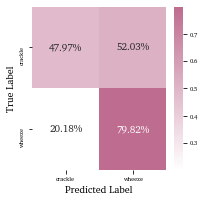

In [9]:
y_pred_de, y_prob_de = get_deep_ensemble_pred_prob(X_test, prediction_fns)

y_prob_de[y_prob_de > 1] = 1
y_prob_de[y_prob_de < 0] = 0


y_true = np.argmax(y_test, axis = 1)
acc, re = get_accuracy_confidence_curve(y_true, y_pred_de, np.max(y_prob_de, axis = 1))

with open(os.getcwd() + f'/pickles/re_acc_de1_{n_classes}class', 'wb') as f:
    pickle.dump((acc, re), f)

figure_path = module_path + '/figures/small_segment_dataset_plots/'

f, ax = utility.plot_cm(y_true, y_pred_de, module_path = module_path,
                        class_names = le.classes_, hex_color_str = '#be6d90')

f.savefig(figure_path + f'cm_deepEnsemble_{n_classes}class.pdf', bbox_inches='tight')


print(classification_report(y_true, y_pred_de))

with open(os.getcwd() + f'/performance/true_pred_deepEnsemble_{n_classes}class', 'wb') as f:
    pickle.dump((y_true, y_pred_de), f)

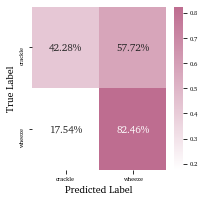

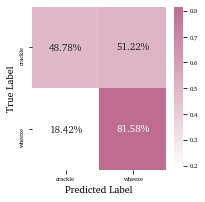

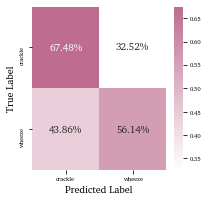

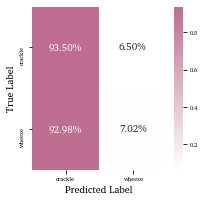

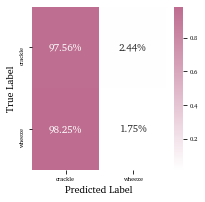

In [10]:
briers_de = []
accs_de = []
eces_de = []
re_acc_de = []
entropy_de = []
counts_de =  []
y_probs_de = []

y_true = np.argmax(y_test, axis = 1)

for X_test_noise in plot_factor[plot_label]:

    y_pred_de, y_prob_de = get_deep_ensemble_pred_prob(X_test_noise, prediction_fns)
    
    y_prob_de[y_prob_de > 1] = 1
    y_prob_de[y_prob_de < 0] = 0
    
    f, ax = utility.plot_cm(y_true, y_pred_de, module_path = module_path,
                        class_names = le.classes_, hex_color_str = '#be6d90')
    plt.show()
    
    y_probs_de.append(np.max(y_prob_de, axis = 1))
    
    entropy_de.append(entr(y_prob_de).sum(axis=0)/np.log(2))
    
    accs_de.append(metrics.accuracy_score(y_true, y_pred_de))
    
    brier = metrics.brier_score_loss(y_true, np.max(y_prob_de, axis = 1))
    briers_de.append(brier)
    
    ece = ECE_score(y_true, y_prob_de)
    eces_de.append(ece)
    
    acc, re = get_accuracy_confidence_curve(y_true, y_pred_de, np.max(y_prob_de, axis = 1))
    re_acc_de.append((re, acc))
    
    counts_de.append(get_count_cuve(y_prob_de))
    
with open(os.getcwd() + f'/pickles/briers_de_{plot_label}', 'wb') as f:
    pickle.dump(briers_de, f)
    
with open(os.getcwd() + f'/pickles/accs_de_{plot_label}', 'wb') as f:
    pickle.dump(accs_de, f)

with open(os.getcwd() + f'/pickles/eces_de_{plot_label}', 'wb') as f:
    pickle.dump(eces_de, f)
    
with open(os.getcwd() + f'/pickles/re_acc_de_{plot_label}', 'wb') as f:
    pickle.dump(re_acc_de, f)
    
with open(os.getcwd() + f'/pickles/entropy_de_{plot_label}', 'wb') as f:
    pickle.dump(entropy_de, f)
    
with open(os.getcwd() + f'/pickles/counts_de_{plot_label}', 'wb') as f:
    pickle.dump(counts_de, f)
    
with open(os.getcwd() + f'/pickles/probs_de_{plot_label}', 'wb') as f:
    pickle.dump(y_probs_de, f)

# Dropout model, and normal model

In [4]:
def get_MC_dropout_model(input_shape):
    #input_shape=(X_train.shape[1], 1)


    model = Sequential()

    model.add(Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=50))
    model.add(Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape))
    #model.add(MonteCarloDropout(0.25))
    model.add(Flatten())
    model.add(Dense(1500, activation='relu'))
    model.add(MonteCarloDropout(0.5))

    #model.add(Dense(500, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizer, metrics=["accuracy"])
    return model
    
def get_model(input_shape):
    #input_shape=(X_train.shape[1], 1)


    model = Sequential()

    model.add(Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=50))
    model.add(Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape))
    #model.add(MonteCarloDropout(0.25))
    model.add(Flatten())
    model.add(Dense(1500, activation='relu'))
    model.add(Dropout(0.5))

    #model.add(Dense(500, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizer, metrics=["accuracy"])
    return model

input_shape=(X_train.shape[1], 1)
batch_size = 100
epochs = 100


model_MC = get_MC_dropout_model(input_shape)

model = get_model(input_shape)

model.fit(X_train, y_train, epochs = epochs,
          batch_size = batch_size,
          verbose = 0,
         validation_data = (X_val, y_val))

start = time()
model_MC.fit(X_train, y_train, epochs = epochs,
          batch_size = batch_size,
          verbose = 0,
         validation_data = (X_val, y_val))

print(f'Time utilized = {time() - start}')

Time utilized = 119.53657913208008


              precision    recall  f1-score   support

           0       0.66      0.61      0.63       123
           1       0.61      0.66      0.63       114

    accuracy                           0.63       237
   macro avg       0.63      0.63      0.63       237
weighted avg       0.63      0.63      0.63       237



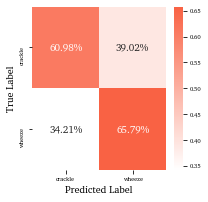

In [6]:
y_pred_mc, y_prob_mc = predict_class(X_test, model_MC, 100)
y_prob = model.predict(X_test) 
y_pred = np.argmax(y_prob, axis = 1)
y_true = np.argmax(y_test, axis = 1)

acc, re = get_accuracy_confidence_curve(y_true, y_pred_mc, np.max(y_prob_mc, axis = 1))

with open(os.getcwd() + f'/pickles/re_acc_mc1_{n_classes}class', 'wb') as f:
    pickle.dump((acc, re), f)

acc, re = get_accuracy_confidence_curve(y_true, y_pred, np.max(y_prob, axis = 1))

with open(os.getcwd() + f'/pickles/re_acc1_{n_classes}class', 'wb') as f:
    pickle.dump((acc, re), f)
    
figure_path = module_path + '/figures/small_segment_dataset_plots/'

f, ax = utility.plot_cm(y_true, y_pred_mc, module_path = module_path,
                        class_names = le.classes_, hex_color_str = '#f96244')

f.savefig(figure_path + f'cm_MCdropout_{n_classes}class.pdf', bbox_inches='tight')


print(classification_report(y_true, y_pred_mc))

with open(os.getcwd() + f'/performance/true_pred_MCdropout_{n_classes}class', 'wb') as f:
    pickle.dump((y_true, y_pred_mc), f)

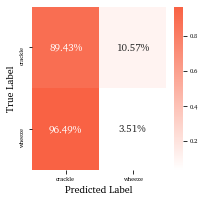

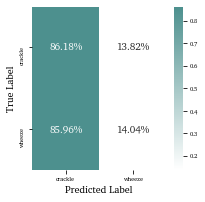

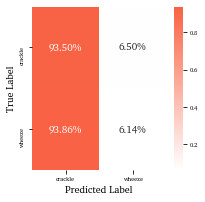

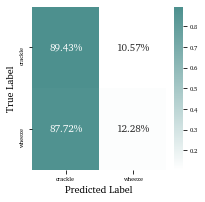

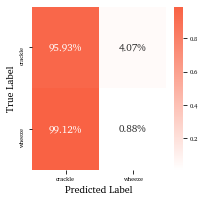

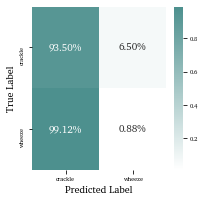

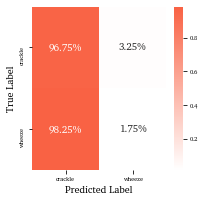

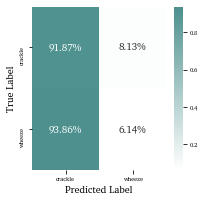

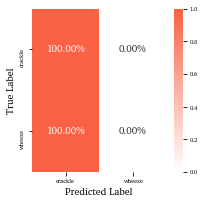

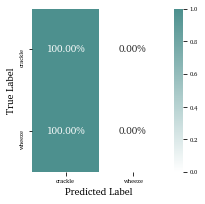

In [11]:
briers = []
accs = []
eces = []
re_acc = []
entropy = []
counts = []

briers_mc = []
accs_mc = []
eces_mc = []
re_acc_mc = []
entropy_mc = []
counts_mc = []

y_probs = []
y_probs_mc = []


y_true = np.argmax(y_test, axis = 1)

for X_test_noise in plot_factor[plot_label]:
    # MC DROPOUT
    y_pred_mc, y_prob_mc = predict_class(X_test_noise, model_MC, 100)
    y_probs_mc.append(np.max(y_prob_mc, axis = 1))
    entropy_mc.append(entr(y_prob_mc).sum(axis=0)/np.log(2))
    
    f, ax = utility.plot_cm(y_true, y_pred_mc, module_path = module_path,
                        class_names = le.classes_, hex_color_str = '#f96244')
    
    accs_mc.append(metrics.accuracy_score(y_true, y_pred_mc))
    
    brier = metrics.brier_score_loss(y_true, np.max(y_prob_mc, axis = 1))
    briers_mc.append(brier)
    
    ece = ECE_score(y_true, y_prob_mc)
    eces_mc.append(ece)
    
    acc, re = get_accuracy_confidence_curve(y_true, y_pred_mc, np.max(y_prob_mc, axis = 1))
    re_acc_mc.append((re, acc))
    
    counts_mc.append(get_count_cuve(y_prob_mc))
    
    # ORIGINAL CNN
    y_prob = model.predict(X_test_noise) 
    y_probs.append(np.max(y_prob, axis = 1))
    y_pred = np.argmax(y_prob, axis = 1)
    
    f, ax = utility.plot_cm(y_true, y_pred, module_path = module_path,
                        class_names = le.classes_, hex_color_str = '#4D908E')
    
    entropy.append(entr(y_prob).sum(axis=0)/np.log(2))
    
    accs.append(metrics.accuracy_score(y_true, y_pred))
    
    brier = metrics.brier_score_loss(y_true, np.max(y_prob, axis = 1))
    briers.append(brier)
    
    ece = ECE_score(y_true, y_prob)
    eces.append(ece)
    
    acc, re = get_accuracy_confidence_curve(y_true, y_pred, np.max(y_prob, axis = 1))
    re_acc.append((re, acc))
    
    counts.append(get_count_cuve(y_prob))
    
    
with open(os.getcwd() + f'/pickles/probs_{plot_label}', 'wb') as f:
    pickle.dump(y_probs, f)
    
with open(os.getcwd() + f'/pickles/probs_mc_{plot_label}', 'wb') as f:
    pickle.dump(y_probs_mc, f)
    
    
with open(os.getcwd() + f'/pickles/briers_mc_{plot_label}', 'wb') as f:
    pickle.dump(briers_mc, f)
    
with open(os.getcwd() + f'/pickles/accs_mc_{plot_label}', 'wb') as f:
    pickle.dump(accs_mc, f)

with open(os.getcwd() + f'/pickles/eces_mc_{plot_label}', 'wb') as f:
    pickle.dump(eces_mc, f)
    
with open(os.getcwd() + f'/pickles/re_acc_mc_{plot_label}', 'wb') as f:
    pickle.dump(re_acc_mc, f)
    
with open(os.getcwd() + f'/pickles/entropy_mc_{plot_label}', 'wb') as f:
    pickle.dump(entropy_mc, f)
    
with open(os.getcwd() + f'/pickles/briers_{plot_label}', 'wb') as f:
    pickle.dump(briers, f)
    
with open(os.getcwd() + f'/pickles/accs_{plot_label}', 'wb') as f:
    pickle.dump(accs, f)

with open(os.getcwd() + f'/pickles/eces_{plot_label}', 'wb') as f:
    pickle.dump(eces, f)
    
with open(os.getcwd() + f'/pickles/re_acc_{plot_label}', 'wb') as f:
    pickle.dump(re_acc, f)
    
with open(os.getcwd() + f'/pickles/entropy_{plot_label}', 'wb') as f:
    pickle.dump(entropy, f)
    
with open(os.getcwd() + f'/pickles/counts_mc_{plot_label}', 'wb') as f:
    pickle.dump(counts_mc, f)
    
with open(os.getcwd() + f'/pickles/counts_{plot_label}', 'wb') as f:
    pickle.dump(counts, f)

# Example, listen after applying augumentation

In [7]:
def get_accuracy_accuracy_rejection_curve(y_test, y_pred, prob):  
    tot = len(y_test)
    def is_in_range(l, u, x):
        return (x < u) & (x > l)
    
    #lower = np.linspace(0.5, 0, 101)[:-1]
    #upper = np.linspace(0.5, 1, 101)[:-1]
    lower = np.linspace(0.5, 0, 10)[:-1]
    upper = np.linspace(0.5, 1, 10)[:-1]
    
    acc = []
    re = []
    

    for r in zip(lower, upper):
        temp_true = y_test.copy()
        temp_pred = y_pred.copy()
        
        reject_samples = is_in_range(r[0], r[1], prob)
        
        if np.any(reject_samples):
            keep_indices = np.where(reject_samples !=  True)[0]
            keep_indices = np.unique(keep_indices)

            temp_true = temp_true[keep_indices]
            temp_pred = temp_pred[keep_indices]
            
        #if len(acc)%10 == 0:
        #    f, ax = utility.plot_cm(temp_true, temp_pred, module_path = module_path)
            
        acc.append(metrics.accuracy_score(temp_true, temp_pred))
        re.append(1 - len(temp_true)/tot)
        
    return acc, re  

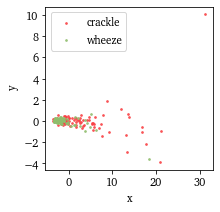

In [33]:
X_train_noise = plot_factor['shift'][-1]
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0],X_train_noise.shape[1])
X_new = helper.get_dim_reduced_X(X_train_noise, 'pca')

f, ax = helper.scatterplot_with_colors(X_new, np.argmax(y_test,axis = 1), module_path = module_path, new_legends = ['crackle', 'wheeze'])

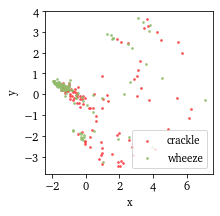

In [32]:
X_train_noise = plot_factor['pitch'][-1]
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0],X_train_noise.shape[1])
X_new = helper.get_dim_reduced_X(X_train_noise, 'pca')

f, ax = helper.scatterplot_with_colors(X_new, np.argmax(y_test,axis = 1), module_path = module_path, new_legends = ['crackle', 'wheeze'])

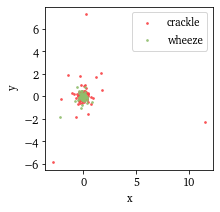

In [31]:
X_train_noise = plot_factor['noise'][-1]
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0],X_train_noise.shape[1])
X_new = helper.get_dim_reduced_X(X_train_noise, 'pca')

f, ax = helper.scatterplot_with_colors(X_new, np.argmax(y_test,axis = 1), module_path = module_path, new_legends = ['crackle', 'wheeze'])

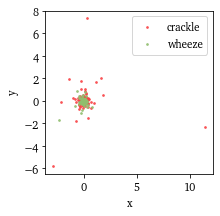

In [30]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])
X_new = helper.get_dim_reduced_X(X_test, 'pca')

f, ax = helper.scatterplot_with_colors(X_new, np.argmax(y_test,axis = 1), module_path = module_path, new_legends = ['crackle', 'wheeze'])

In [65]:
t = np.hstack(X_train_noise[658])
t1 = manipulate_pitch(t, 8000, 1)

ipd.Audio(t1, rate = 8000) # load a local WAV file

In [64]:
import IPython.display as ipd

t = np.hstack(X_train[658])
t1 = manipulate_pitch(t, 8000, 1)

ipd.Audio(t1, rate = 8000) # load a local WAV file

In [ ]:

ipd.Audio(t, rate = 8000) # load a local WAV file